# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Project
# Alzheimer’s Disease and Cognitive Impairment Prediction



---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):E109A

Import libraries:

In [6]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display

from sklearn import linear_model
import copy
from sklearn import preprocessing
import sklearn.discriminant_analysis as da
from sklearn.grid_search import GridSearchCV
from sklearn import tree
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
%matplotlib inline


## Multiclass Alzheimer’s Disease and Cognitive Impairment Classification

In this problem, you will build a model for diagnosing disorders in a patient's cognitive impairment. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *cognitive normal* (class 0)
- having *dementia* (class 1)
- or having *MCI* (class 2). 

The data set is provided in the file `adnimerge.csv`. 

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the ADNI.



In [3]:
np.random.seed(9001)

#note: data is already sorted before loading
df = pd.read_csv('data/ADNIMERGE.csv')
print(df.shape)
print(df[0:2])


(13017, 94)
   RID        PTID VISCODE  SITE COLPROT ORIGPROT  EXAMDATE DX_bl   AGE  \
0    2  011_S_0002      bl    11   ADNI1    ADNI1  9/8/2005    CN  74.3   
1    2  011_S_0002     m06    11   ADNI1    ADNI1  3/6/2006    CN  74.3   

  PTGENDER      ...       EcogSPDivatt_bl EcogSPTotal_bl   FDG_bl PIB_bl  \
0     Male      ...                   NaN            NaN  1.36926    NaN   
1     Male      ...                   NaN            NaN  1.36926    NaN   

   AV45_bl  Years_bl  Month_bl  Month  M  update_stamp  
0      NaN  0.000000   0.00000      0  0       50:48.0  
1      NaN  0.490075   5.86885      6  6       50:48.0  

[2 rows x 94 columns]


## 1.1 generate DX_last and DX_change, DX_last is the most recent available diagnosis of a patient.  


In [4]:
#this is a test just for on RID
#datapre-precessing
x_dist=df.RID.unique()
temp_df=df.loc[(df['RID']==2)]


temp_df_fill=copy.copy(temp_df)
temp_df_fill['DX']=temp_df['DX'].fillna(method='bfill')

temp_df_fill.to_csv('data/temp_df_fill_bf.csv')
temp_df_fill['DX']=temp_df_fill['DX'].fillna(method='ffill')
temp_df_fill.to_csv('data/temp_df_fill_ff.csv')
temp_df_fill['DX_last']=copy.copy(temp_df_fill.DX)

#add a new field DX_change, if there is a categorical change for one participant, then it will be 1, this will be used
# to move data

#temp_df_fill['DX_change']=0
col_last=temp_df_fill.shape[1]


tmp_value=temp_df_fill.iloc[temp_df_fill.shape[0]-1,temp_df_fill.shape[1]-2]
    
for i in range(0,temp_df_fill.shape[0]-1):
  
    temp_df_fill.iloc[i,col_last-2]=tmp_value

    
temp_df_fill.to_csv('data/temp_df_fill_ff_DX_last.csv')
print(temp_df_fill[0:2])


   RID        PTID VISCODE  SITE COLPROT ORIGPROT  EXAMDATE DX_bl   AGE  \
0    2  011_S_0002      bl    11   ADNI1    ADNI1  9/8/2005    CN  74.3   
1    2  011_S_0002     m06    11   ADNI1    ADNI1  3/6/2006    CN  74.3   

  PTGENDER   ...     EcogSPTotal_bl   FDG_bl PIB_bl AV45_bl  Years_bl  \
0     Male   ...                NaN  1.36926    NaN     NaN  0.000000   
1     Male   ...                NaN  1.36926    NaN     NaN  0.490075   

   Month_bl  Month  M  update_stamp  DX_last  
0   0.00000      0  0       50:48.0       CN  
1   5.86885      6  6       50:48.0       CN  

[2 rows x 95 columns]


In [5]:
#create DX_last, DX_change, backfill/forward fill to get DX_last, and BILAVAMT, BILAVVOL, 
x_dist=df.RID.unique()
#x_dist[0:10]
df_fill=pd.DataFrame()
count=1
for i in x_dist:
    temp_df=pd.DataFrame()
    temp_df_fill=pd.DataFrame()
    
    temp_df=df.loc[(df['RID']==i)]
 
    temp_df_fill=copy.copy(temp_df)
    temp_df_fill['DX']=temp_df['DX'].fillna(method='bfill')

    temp_df_fill['DX']=temp_df['DX'].fillna(method='ffill')
  

    temp_df_fill['DX_last']=copy.copy(temp_df_fill.DX)
  
    if(temp_df_fill.shape[0]>1):
        col_last=df_fill.shape[1]
        tmp_value=temp_df_fill.iloc[temp_df_fill.shape[0]-1,temp_df_fill.shape[1]-2]

        for i in range(0,temp_df_fill.shape[0]-1):
            temp_df_fill.iloc[i,col_last-2]=tmp_value

    if (count==1):
        df_fill=temp_df_fill
    else:
        df_fill=pd.concat([df_fill, temp_df_fill], axis=0)
    count=count+1
    
    
temp_df_fill.to_csv('data/temp_df_fill_ff_DX_last.csv')


df_fill.to_csv('data/df_fill_DX_last.csv')

print(df_fill[0:2])

   RID        PTID VISCODE  SITE COLPROT ORIGPROT  EXAMDATE DX_bl   AGE  \
0    2  011_S_0002      bl    11   ADNI1    ADNI1  9/8/2005    CN  74.3   
1    2  011_S_0002     m06    11   ADNI1    ADNI1  3/6/2006    CN  74.3   

  PTGENDER   ...     EcogSPTotal_bl   FDG_bl PIB_bl AV45_bl  Years_bl  \
0     Male   ...                NaN  1.36926    NaN     NaN  0.000000   
1     Male   ...                NaN  1.36926    NaN     NaN  0.490075   

   Month_bl  Month  M  update_stamp  DX_last  
0   0.00000      0  0       50:48.0       CN  
1   5.86885      6  6       50:48.0       CN  

[2 rows x 95 columns]


In [7]:
print(df_fill.columns)

Index(['RID', 'PTID', 'VISCODE', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION',
       'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform',
       'MidTemp', 'ICV', 'DX', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl',
       'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl',
       'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'FAQ_bl',
       'FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl',
       'WholeBrain_bl', 'Entorhinal_bl

In [7]:
#drop columns that doesnt have relevent or enough data
column_drop_clean=['PIB', 'AV45','MOCA', 'EcogPtMem', 'EcogPtLang',
       'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
       'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
       'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal','EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl',
       'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl',
       'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'FAQ_bl',
       'FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl',
       'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl',
       'MOCA_bl', 'EcogPtMem_bl', 'EcogPtLang_bl', 'EcogPtVisspat_bl',
       'EcogPtPlan_bl', 'EcogPtOrgan_bl', 'EcogPtDivatt_bl', 'EcogPtTotal_bl',
       'EcogSPMem_bl', 'EcogSPLang_bl', 'EcogSPVisspat_bl', 'EcogSPPlan_bl',
       'EcogSPOrgan_bl', 'EcogSPDivatt_bl', 'EcogSPTotal_bl', 'FDG_bl',
       'PIB_bl', 'AV45_bl', 'Years_bl', 'Month_bl', 'Month', 'M',
       'update_stamp']

df_fill_test=df_fill.drop(column_drop_clean, axis=1)
df_fill_test.to_csv('data/df_fill_drop_bio.csv')

print(df_fill_test.shape)

(13017, 36)


In [21]:

df_fill_drop=copy.copy(df_fill_test)
df_fill_drop=df_fill_drop.dropna()
#also drop those that with DX_change=1
#df_fill_drop=df_fill_drop.loc[(df_fill_drop['DX_change']==0)]
df_fill_drop.to_csv('data/df_fill_drop_DX_change_bio.csv')
print(df_fill_drop.shape)

(2160, 36)


In [22]:
#drop some columns

#df_fill_drop_clean=df_fill_drop.drop('Unnamed: 0', axis=1)
df_fill_drop_clean=df_fill_drop.drop('PTID', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('VISCODE', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('SITE', axis=1)
#COLPROT will be dropped once all the data preprocess is done
#df_fill_drop_clean=df_fill_drop_clean.drop('COLPROT', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('ORIGPROT', axis=1)
df_fill_drop_clean=df_fill_drop_clean.drop('EXAMDATE', axis=1)

#from biomark file
#df_fill_drop_clean=df_fill_drop_clean.drop('Phase', axis=1)


print(df_fill_drop_clean[0:2])


    RID COLPROT DX_bl   AGE PTGENDER  PTEDUCAT         PTETHCAT PTRACCAT  \
0     2   ADNI1    CN  74.3     Male        16  Not Hisp/Latino    White   
14    3   ADNI1    AD  81.3     Male        18  Not Hisp/Latino    White   

    PTMARRY  APOE4    ...     \
0   Married    0.0    ...      
14  Married    1.0    ...      

                                            FSVERSION  Ventricles  \
0   Cross-Sectional FreeSurfer (FreeSurfer Version...    118233.0   
14  Cross-Sectional FreeSurfer (FreeSurfer Version...     84599.0   

    Hippocampus  WholeBrain  Entorhinal  Fusiform  MidTemp        ICV  \
0        8336.0   1229740.0      4177.0   16559.0  27936.0  1984660.0   
14       5319.0   1129830.0      1791.0   15506.0  18422.0  1920690.0   

          DX   DX_last  
0         CN        CN  
14  Dementia  Dementia  

[2 rows x 31 columns]


In [23]:
print(df_fill_drop_clean.columns)

Index(['RID', 'COLPROT', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT',
       'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'DX_last'],
      dtype='object')


## 1.2: preliminary EDA

In [24]:
#adding dummy variables
categorical_columns_drop = ['DX_bl', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT','PTMARRY','FLDSTRENG',
                            'FSVERSION','DX','DX_last']
#categorical_columns = ['DX_bl_cat', 'PTGENDER_cat', 'PTEDUCAT_cat', 'PTETHCAT_cat', 'PTRACCAT_cat','PTMARRY_cat'
#                       ,'FLDSTRENG_cat','FSVERSION_cat']
categorical_columns = ['PTGENDER_cat', 'PTEDUCAT_cat', 'PTETHCAT_cat', 'PTRACCAT_cat','PTMARRY_cat'
                       ,'FLDSTRENG_cat','FSVERSION_cat']

#categorical_columns_g2cols = ['season', 'month', 'day_of_week', 'weather']
numerical_columns = ['AGE', 'APOE4', 'FDG', 'CDRSB','ADAS11','ADAS13','MMSE',
                     'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ',
                     'Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV']

In [25]:
#df_fill_drop_clean["DX_bl"] = df_fill_drop_clean["DX_bl"].astype('category')
#df_fill_drop_clean["DX_bl_cat"] = df_fill_drop_clean["DX_bl"].cat.codes

df_fill_drop_clean["PTGENDER"] = df_fill_drop_clean["PTGENDER"].astype('category')
df_fill_drop_clean["PTGENDER_cat"] = df_fill_drop_clean["PTGENDER"].cat.codes

df_fill_drop_clean["PTEDUCAT"] = df_fill_drop_clean["PTEDUCAT"].astype('category')
df_fill_drop_clean["PTEDUCAT_cat"] = df_fill_drop_clean["PTEDUCAT"].cat.codes

df_fill_drop_clean["PTETHCAT"] = df_fill_drop_clean["PTETHCAT"].astype('category')
df_fill_drop_clean["PTETHCAT_cat"] = df_fill_drop_clean["PTETHCAT"].cat.codes

df_fill_drop_clean["PTRACCAT"] = df_fill_drop_clean["PTRACCAT"].astype('category')
df_fill_drop_clean["PTRACCAT_cat"] = df_fill_drop_clean["PTRACCAT"].cat.codes

df_fill_drop_clean["PTMARRY"] = df_fill_drop_clean["PTMARRY"].astype('category')
df_fill_drop_clean["PTMARRY_cat"] = df_fill_drop_clean["PTMARRY"].cat.codes

df_fill_drop_clean["FLDSTRENG"] = df_fill_drop_clean["FLDSTRENG"].astype('category')
df_fill_drop_clean["FLDSTRENG_cat"] = df_fill_drop_clean["FLDSTRENG"].cat.codes


df_fill_drop_clean["FSVERSION"] = df_fill_drop_clean["FSVERSION"].astype('category')
df_fill_drop_clean["FSVERSION_cat"] = df_fill_drop_clean["FSVERSION"].cat.codes

df_fill_drop_clean["DX_last"] = df_fill_drop_clean["DX_last"].astype('category')
df_fill_drop_clean["DX_last_cat"] = df_fill_drop_clean["DX_last"].cat.codes

print(df_fill_drop_clean[0:2])

    RID COLPROT DX_bl   AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
0     2   ADNI1    CN  74.3     Male       16  Not Hisp/Latino    White   
14    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   

    PTMARRY  APOE4     ...             DX   DX_last  PTGENDER_cat  \
0   Married    0.0     ...             CN        CN             1   
14  Married    1.0     ...       Dementia  Dementia             1   

    PTEDUCAT_cat  PTETHCAT_cat  PTRACCAT_cat  PTMARRY_cat  FLDSTRENG_cat  \
0             10             1             6            1              0   
14            12             1             6            1              0   

    FSVERSION_cat  DX_last_cat  
0               1            0  
14              1            1  

[2 rows x 39 columns]


In [26]:
df_fill_drop_clean.to_csv('data/df_fill_drop_clean.csv')

In [27]:
df_fill_drop_clean.dtypes

RID                         int64
COLPROT                    object
DX_bl                      object
AGE                       float64
PTGENDER                 category
PTEDUCAT                 category
PTETHCAT                 category
PTRACCAT                 category
PTMARRY                  category
APOE4                     float64
FDG                       float64
CDRSB                     float64
ADAS11                    float64
ADAS13                    float64
MMSE                      float64
RAVLT_immediate           float64
RAVLT_learning            float64
RAVLT_forgetting          float64
RAVLT_perc_forgetting     float64
FAQ                       float64
FLDSTRENG                category
FSVERSION                category
Ventricles                float64
Hippocampus               float64
WholeBrain                float64
Entorhinal                float64
Fusiform                  float64
MidTemp                   float64
ICV                       float64
DX            

## 1.3: adding dummy variables

In [28]:
#df_fill_drop_clean["DX_bl_cat"] = df_fill_drop_clean["DX_bl_cat"].astype('int64')

df_fill_drop_clean_dummy = pd.get_dummies(df_fill_drop_clean, columns=categorical_columns, drop_first=True)
#df_fill_drop_clean_dumm=df_fill_drop_clean_dummy.drop(categorical_columns_drop,axis=1)
#df_fill_drop_clean_dumm=df_fill_drop_clean_dummy.drop('PTMARRY_cat_2',axis=1)
print(df_fill_drop_clean_dummy[0:2])
print(df_fill_drop_clean_dummy.shape)
#drop those categorical column that are strings


    RID COLPROT DX_bl   AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
0     2   ADNI1    CN  74.3     Male       16  Not Hisp/Latino    White   
14    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   

    PTMARRY  APOE4       ...         PTRACCAT_cat_3  PTRACCAT_cat_4  \
0   Married    0.0       ...                      0               0   
14  Married    1.0       ...                      0               0   

    PTRACCAT_cat_5  PTRACCAT_cat_6  PTMARRY_cat_1  PTMARRY_cat_2  \
0                0               1              1              0   
14               0               1              1              0   

    PTMARRY_cat_3  PTMARRY_cat_4  FLDSTRENG_cat_1  FSVERSION_cat_1  
0               0              0                0                1  
14              0              0                0                1  

[2 rows x 61 columns]
(2160, 61)


In [29]:
print(df_fill_drop_clean.columns)

Index(['RID', 'COLPROT', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT',
       'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'DX_last', 'PTGENDER_cat', 'PTEDUCAT_cat', 'PTETHCAT_cat',
       'PTRACCAT_cat', 'PTMARRY_cat', 'FLDSTRENG_cat', 'FSVERSION_cat',
       'DX_last_cat'],
      dtype='object')


## 1.3: split data into train/test and scale data

In [30]:
#split data between train and test
np.random.seed(9001)
#use data with COLPROT = ADNI1 and then split
df_ADNI=df_fill_drop_clean_dummy.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNI1']
print(df_ADNI.shape,df_ADNI[0:2])
msk = np.random.rand(len(df_ADNI)) < 0.5

data_train_ADNI=df_fill_drop_clean.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNI1']
data_train_EDA=data_train_ADNI[msk]

data_train_raw = df_ADNI[msk]
data_test_raw = df_ADNI[~msk]


(1270, 61)     RID COLPROT DX_bl   AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
0     2   ADNI1    CN  74.3     Male       16  Not Hisp/Latino    White   
14    3   ADNI1    AD  81.3     Male       18  Not Hisp/Latino    White   

    PTMARRY  APOE4       ...         PTRACCAT_cat_3  PTRACCAT_cat_4  \
0   Married    0.0       ...                      0               0   
14  Married    1.0       ...                      0               0   

    PTRACCAT_cat_5  PTRACCAT_cat_6  PTMARRY_cat_1  PTMARRY_cat_2  \
0                0               1              1              0   
14               0               1              1              0   

    PTMARRY_cat_3  PTMARRY_cat_4  FLDSTRENG_cat_1  FSVERSION_cat_1  
0               0              0                0                1  
14              0              0                0                1  

[2 rows x 61 columns]


In [31]:
#get test data as ADNI2 and ADNIGO

df_ADNI2=df_fill_drop_clean_dummy.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNI2']
df_ADNIGO=df_fill_drop_clean_dummy.loc[df_fill_drop_clean_dummy['COLPROT']=='ADNIGO']

#scale the data
mean = data_train_raw[numerical_columns].mean()
std = data_train_raw[numerical_columns].std()

#mean_t = test_df[numerical_columns].mean()
#std_t = test_df[numerical_columns].std()

data_train_raw[numerical_columns] = (data_train_raw[numerical_columns] - mean)/std
data_test_raw[numerical_columns] = (data_test_raw[numerical_columns] - mean)/std

df_ADNI2[numerical_columns] = (df_ADNI2[numerical_columns] - mean)/std
df_ADNIGO[numerical_columns] = (df_ADNIGO[numerical_columns] - mean)/std

print(df_ADNI2.shape,df_ADNIGO.shape)

print(data_train_raw[0:2])
print(data_test_raw[0:2])



C:\Anaconda3\lib\site-packages\pandas\core\frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


(716, 61) (174, 61)
    RID COLPROT DX_bl       AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
0     2   ADNI1    CN -0.010653     Male       16  Not Hisp/Latino    White   
25    5   ADNI1    CN -0.101550     Male       16  Not Hisp/Latino    White   

    PTMARRY     APOE4       ...         PTRACCAT_cat_3  PTRACCAT_cat_4  \
0   Married -0.869105       ...                      0               0   
25  Married -0.869105       ...                      0               0   

    PTRACCAT_cat_5  PTRACCAT_cat_6  PTMARRY_cat_1  PTMARRY_cat_2  \
0                0               1              1              0   
25               0               1              1              0   

    PTMARRY_cat_3  PTMARRY_cat_4  FLDSTRENG_cat_1  FSVERSION_cat_1  
0               0              0                0                1  
25              0              0                0                1  

[2 rows x 61 columns]
    RID COLPROT DX_bl       AGE PTGENDER PTEDUCAT         PTETHCAT PTRACCAT  \
14   

## 2.1 EDA


In [32]:
print(data_train_EDA.columns)

Index(['RID', 'COLPROT', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT',
       'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13',
       'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'DX_last', 'PTGENDER_cat', 'PTEDUCAT_cat', 'PTETHCAT_cat',
       'PTRACCAT_cat', 'PTMARRY_cat', 'FLDSTRENG_cat', 'FSVERSION_cat',
       'DX_last_cat'],
      dtype='object')


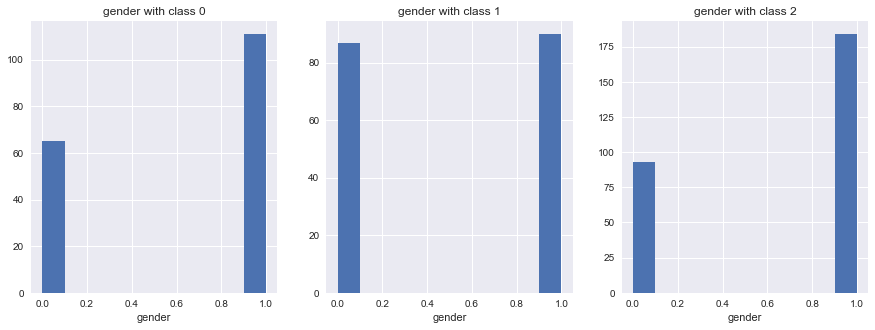

In [33]:
#gender
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#
#ax[0].scatter(data_fillNA_delay[['SCHEDULED_TIME']], data_fillNA_delay[['ARRIVAL_DELAY']], alpha=1.0)
ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTGENDER_cat'])
#ax.axhline(y=mean_pert, color='blue', label='zero error')

ax[0].set_xlabel('gender')
#ax[0].set_ylabel('Delay or not')
ax[0].set_title('gender with class 0')
                 
#ax[1].scatter(data_fillNA_delay[['ELAPSED_TIME']], data_fillNA_delay[['ARRIVAL_DELAY']], alpha=1.0)
#df.loc[df['DX_last'] == 0]

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTGENDER_cat'])
ax[1].set_xlabel('gender')
#ax[1].set_ylabel('Delay or not')
ax[1].set_title('gender with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTGENDER_cat'])
ax[2].set_xlabel('gender')
#ax[1].set_ylabel('Delay or not')
ax[2].set_title('gender with class 2')

plt.show()

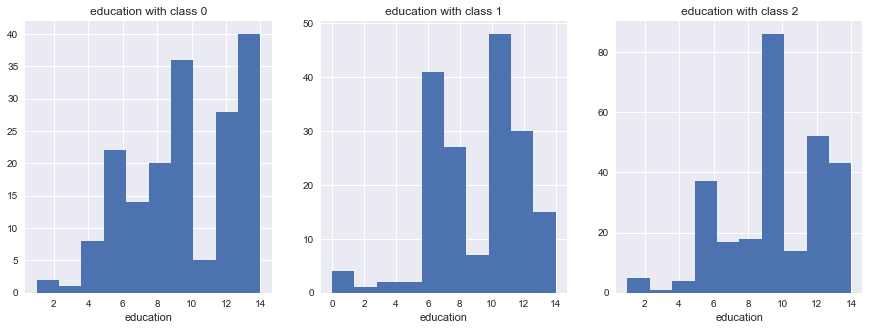

In [34]:
#education
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTEDUCAT_cat'])

ax[0].set_xlabel('education')

ax[0].set_title('education with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTEDUCAT_cat'])
ax[1].set_xlabel('education')

ax[1].set_title('education with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTEDUCAT_cat'])
ax[2].set_xlabel('education')

ax[2].set_title('education with class 2')

plt.show()

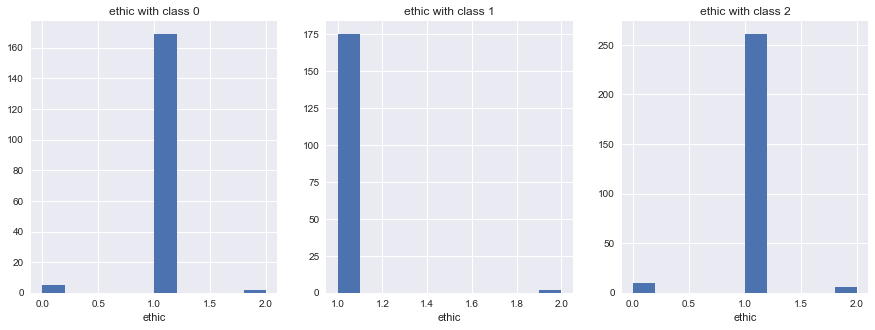

In [35]:
#ethic
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTETHCAT_cat'])

ax[0].set_xlabel('ethic')

ax[0].set_title('ethic with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTETHCAT_cat'])
ax[1].set_xlabel('ethic')

ax[1].set_title('ethic with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTETHCAT_cat'])
ax[2].set_xlabel('ethic')

ax[2].set_title('ethic with class 2')

plt.show()

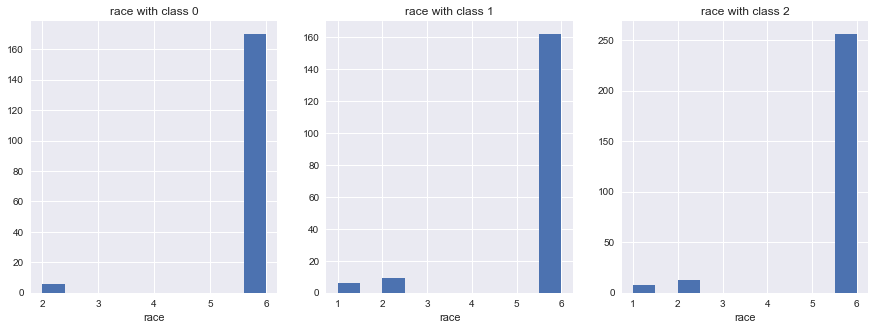

In [36]:
#race
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTRACCAT_cat'])

ax[0].set_xlabel('race')

ax[0].set_title('race with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTRACCAT_cat'])
ax[1].set_xlabel('race')

ax[1].set_title('race with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTRACCAT_cat'])
ax[2].set_xlabel('race')

ax[2].set_title('race with class 2')

plt.show()

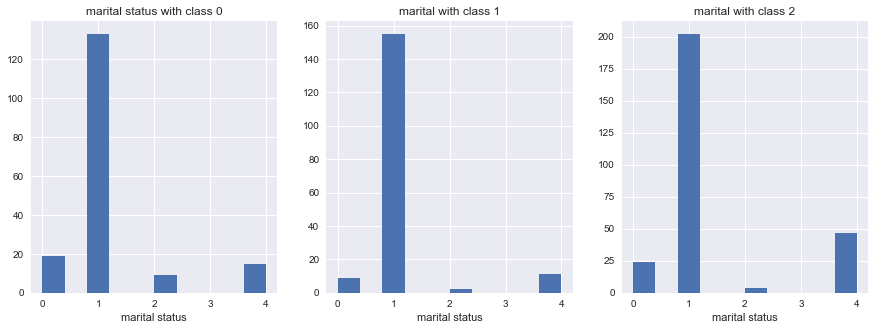

In [37]:
#marital status
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['PTMARRY_cat'])

ax[0].set_xlabel('marital status')

ax[0].set_title('marital status with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['PTMARRY_cat'])
ax[1].set_xlabel('marital status')

ax[1].set_title('marital with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['PTMARRY_cat'])
ax[2].set_xlabel('marital status')

ax[2].set_title('marital with class 2')

plt.show()

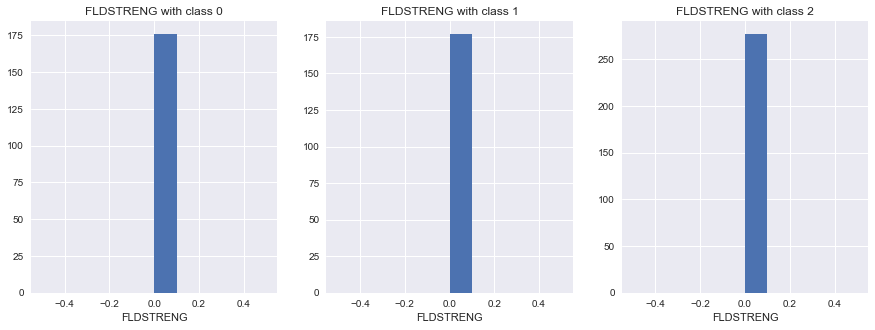

In [38]:
#marital status
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['FLDSTRENG_cat'])

ax[0].set_xlabel('FLDSTRENG')

ax[0].set_title('FLDSTRENG with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['FLDSTRENG_cat'])
ax[1].set_xlabel('FLDSTRENG')

ax[1].set_title('FLDSTRENG with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['FLDSTRENG_cat'])
ax[2].set_xlabel('FLDSTRENG')

ax[2].set_title('FLDSTRENG with class 2')

plt.show()

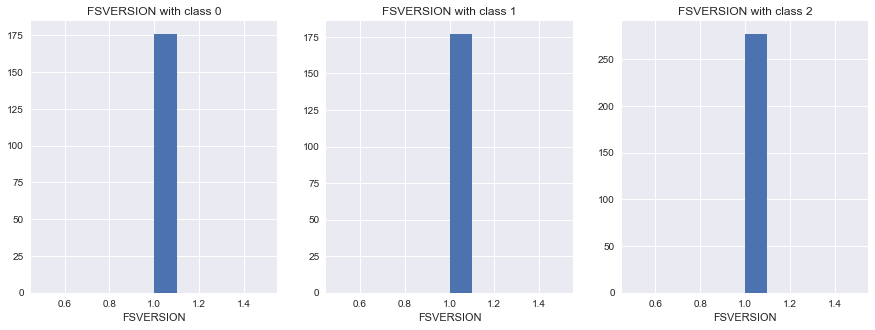

In [39]:
#FSVERSION_cat
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 0]['FSVERSION_cat'])

ax[0].set_xlabel('FSVERSION')

ax[0].set_title('FSVERSION with class 0')
                 

ax[1].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 1]['FSVERSION_cat'])
ax[1].set_xlabel('FSVERSION')

ax[1].set_title('FSVERSION with class 1')

ax[2].hist(data_train_EDA.loc[data_train_EDA['DX_last_cat'] == 2]['FSVERSION_cat'])
ax[2].set_xlabel('FSVERSION')

ax[2].set_title('FSVERSION with class 2')

plt.show()

In [40]:
data_train=copy.copy(data_train_raw.drop('RID',axis=1))
data_train=data_train.drop('COLPROT',axis=1)

data_test=data_test_raw.drop('RID',axis=1)
data_test=data_test.drop('COLPROT',axis=1)

df_ADNI2=df_ADNI2.drop('RID',axis=1)
df_ADNI2=df_ADNI2.drop('COLPROT',axis=1)

df_ADNIGO=df_ADNIGO.drop('RID',axis=1)
df_ADNIGO=df_ADNIGO.drop('COLPROT',axis=1)



In [41]:
data_train.to_csv('data/data_train.csv')
data_test.to_csv('data/data_test.csv')

df_ADNI2.to_csv('data/df_ADNI2.csv')
df_ADNIGO.to_csv('data/df_ADNIGO.csv')


In [42]:
print(data_train.columns)
print(data_train_raw.columns)

Index(['DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'FDG', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
       'RAVLT_perc_forgetting', 'FAQ', 'FLDSTRENG', 'FSVERSION', 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV',
       'DX', 'DX_last', 'DX_last_cat', 'PTGENDER_cat_1', 'PTEDUCAT_cat_1',
       'PTEDUCAT_cat_2', 'PTEDUCAT_cat_3', 'PTEDUCAT_cat_4', 'PTEDUCAT_cat_5',
       'PTEDUCAT_cat_6', 'PTEDUCAT_cat_7', 'PTEDUCAT_cat_8', 'PTEDUCAT_cat_9',
       'PTEDUCAT_cat_10', 'PTEDUCAT_cat_11', 'PTEDUCAT_cat_12',
       'PTEDUCAT_cat_13', 'PTEDUCAT_cat_14', 'PTETHCAT_cat_1',
       'PTETHCAT_cat_2', 'PTRACCAT_cat_1', 'PTRACCAT_cat_2', 'PTRACCAT_cat_3',
       'PTRACCAT_cat_4', 'PTRACCAT_cat_5', 'PTRACCAT_cat_6', 'PTMARRY_cat_1',
       'PTMARRY_cat_2', 'PTMARRY_cat_3', 'PTMARRY_cat_4', 'FLDSTRENG_cat_1',
       'FSVERSION_cat_1'],
      dtype='o

In [43]:
#drop those categorical predictors as they has been converted to dummy variable
print(categorical_columns_drop)
data_train=data_train.drop(categorical_columns_drop,axis=1)
data_test=data_test.drop(categorical_columns_drop,axis=1)
df_ADNI2=df_ADNI2.drop(categorical_columns_drop,axis=1)
df_ADNIGO=df_ADNIGO.drop(categorical_columns_drop,axis=1)

#print(df_fill_drop_clean_dummy[0:10])

['DX_bl', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'FLDSTRENG', 'FSVERSION', 'DX', 'DX_last']


In [44]:
print(data_train.head())
print(data_train.columns)
print(data_train.describe())

         AGE     APOE4       FDG     CDRSB    ADAS11    ADAS13      MMSE  \
0  -0.010653 -0.869105  1.202421 -0.956938 -0.192726 -0.032886  0.438849   
25 -0.101550 -0.869105  0.755566 -0.956938 -0.456135 -0.401388  0.725055   
44  1.534603 -0.869105  0.619447 -0.956938 -0.939492 -1.107990  0.438849   
59 -0.071251  0.602766 -0.612525  0.136011  0.289313  0.488544 -0.133563   
60 -0.071251  0.602766 -1.049223  0.791781  1.474656  1.501925 -0.419769   

    RAVLT_immediate  RAVLT_learning  RAVLT_forgetting       ...         \
0          1.007641        0.143913          0.805687       ...          
25         0.434704        0.143913         -0.071725       ...          
44         1.580578        1.316307         -0.510431       ...          
59        -0.956713       -1.028481         -0.510431       ...          
60        -0.874865       -0.637683          0.366981       ...          

    PTRACCAT_cat_3  PTRACCAT_cat_4  PTRACCAT_cat_5  PTRACCAT_cat_6  \
0                0          

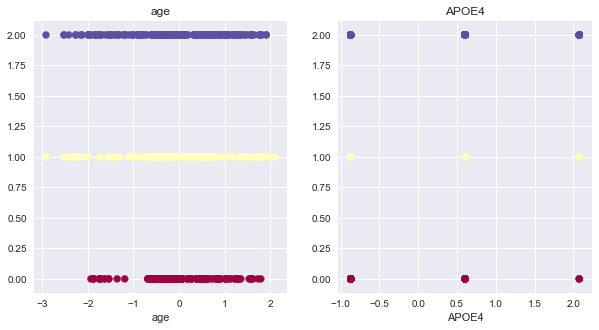

In [46]:
#scatter plot
#age

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

colorMap = plt.get_cmap('Spectral')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['AGE']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('age')
ax[0].set_title('age')
                 
ax[1].scatter(data_train[['APOE4']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)

ax[1].set_xlabel('APOE4')
ax[1].set_title('APOE4')
plt.show()

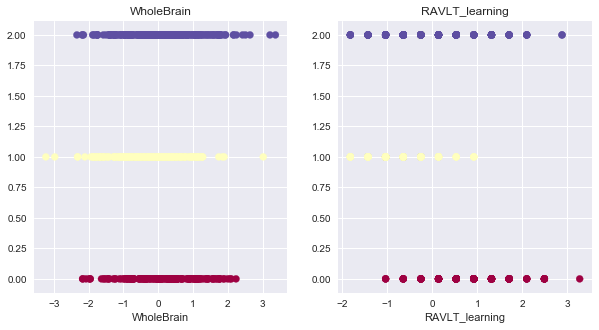

In [47]:
#scatter plot
#WholeBrain

colorMap = plt.get_cmap('Spectral')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['WholeBrain']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('WholeBrain')
ax[0].set_title('WholeBrain')

#RAVLT_learning
ax[1].scatter(data_train[['RAVLT_learning']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)

ax[1].set_xlabel('RAVLT_learning')
ax[1].set_title('RAVLT_learning')
plt.show()

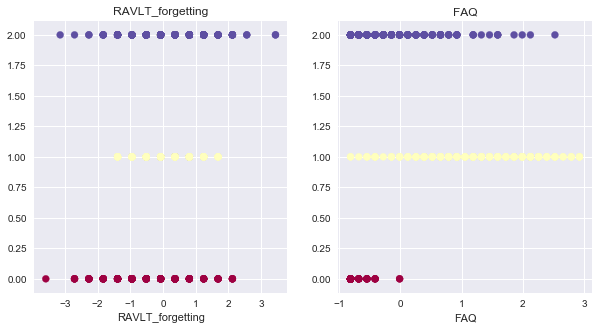

In [48]:
#scatter plot
#RAVLT_forgetting

colorMap = plt.get_cmap('Spectral')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#
ax[0].scatter(data_train[['RAVLT_forgetting']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)
#ax[0].hist(data_fillNA_delay["SCHEDULED_TIME"])
ax[0].set_xlabel('RAVLT_forgetting')
ax[0].set_title('RAVLT_forgetting')

#FAQ
ax[1].scatter(data_train[['FAQ']],data_train[['DX_last_cat']], alpha=1.0, c=data_train[['DX_last_cat']],cmap=colorMap)

ax[1].set_xlabel('FAQ')
ax[1].set_title('FAQ')
plt.show()

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


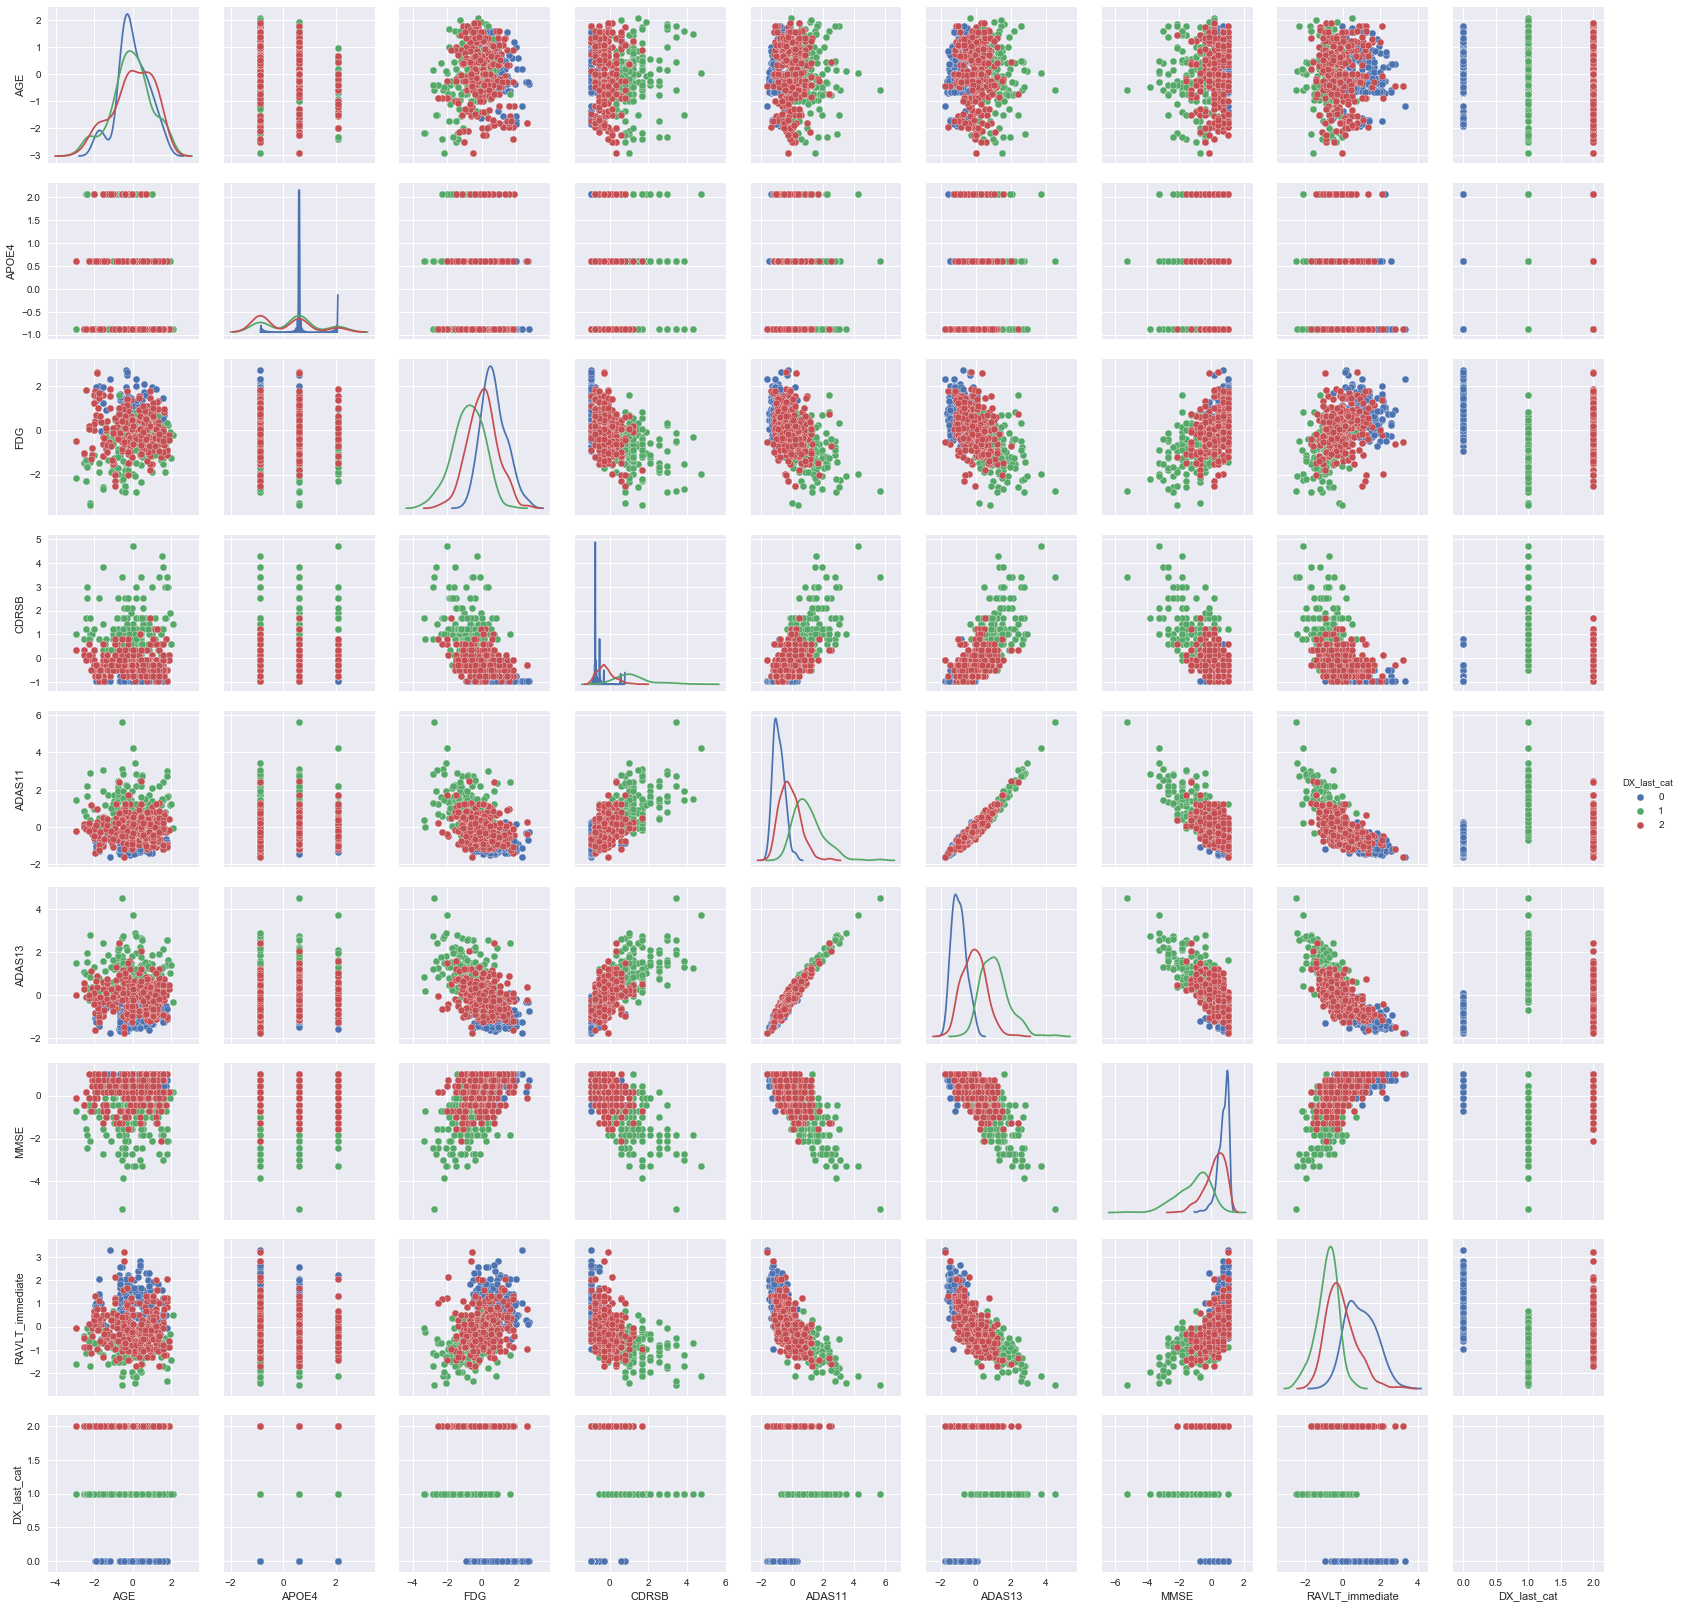

In [49]:
numerical_columns_plot_1= ['AGE', 'APOE4', 'FDG', 'CDRSB','ADAS11','ADAS13','MMSE','RAVLT_immediate','DX_last_cat']
sns.pairplot(data_train, vars=numerical_columns_plot_1, hue="DX_last_cat", size=2.5, diag_kind='kde');

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


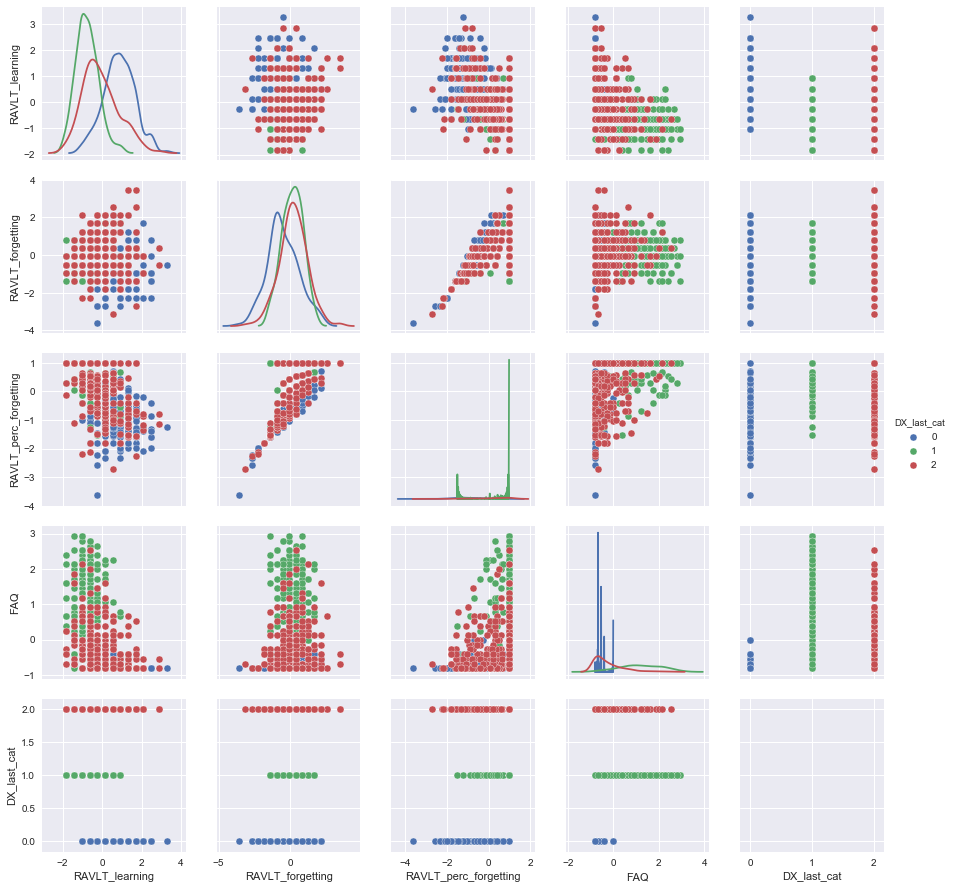

In [50]:
numerical_columns_plot_2= ['RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','FAQ','DX_last_cat']
sns.pairplot(data_train, vars=numerical_columns_plot_2, hue="DX_last_cat", size=2.5,diag_kind='kde');

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


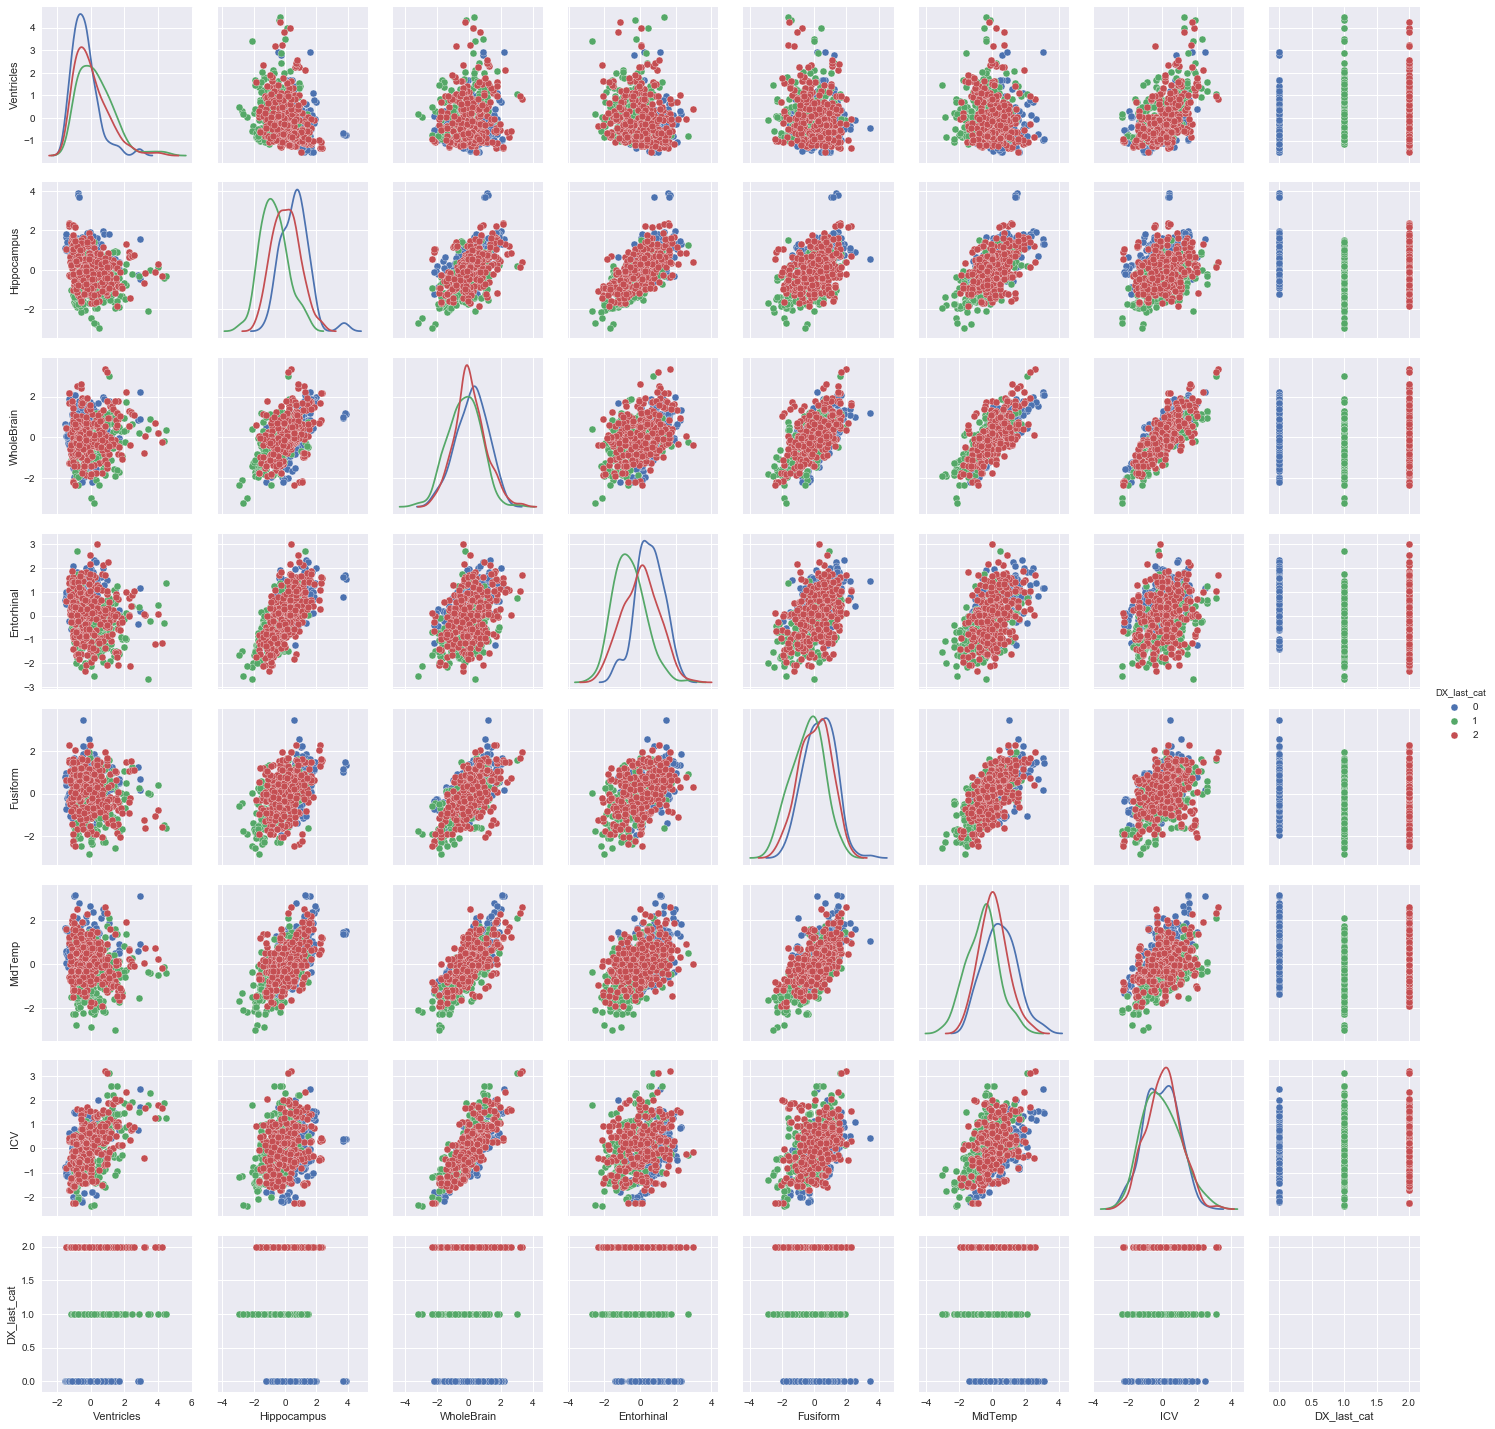

In [51]:
numerical_columns_plot_3= ['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp',
                           'ICV','DX_last_cat']
sns.pairplot(data_train, vars=numerical_columns_plot_3, hue="DX_last_cat", size=2.5, diag_kind='kde');

## based on above three pairwise plot, some predictors shows strong correlation between, some also shows clear regin between classes.

## 2.2 train model over ADNI1 and test on ADNI1 , ADNI2, and ADNIGO.baseline model is logistic regression model, tuned by cross validation. multinomial and OvR, LDA, QDA, KNN and decsion tree are tried. with base model and decision tree the best performance. depth =3, only three predictors are needed, which fit the need to find the most effective way to diagnose.

In [52]:
#get X_train and y_train, X_test, y_test
X_train=copy.copy(data_train)
X_train=X_train.drop('DX_last_cat',axis=1)
#X_train=X_train.drop('RID',axis=1)
#X_train=X_train.drop('COLPROT',axis=1)
y_train=copy.copy(data_train['DX_last_cat'])


X_test=copy.copy(data_test)
X_test=X_test.drop('DX_last_cat',axis=1)
#X_test=X_test.drop('RID',axis=1)
#X_test=X_test.drop('COLPROT',axis=1)

y_test=copy.copy(data_test['DX_last_cat'])

X_test_ADNI2=copy.copy(df_ADNI2)
X_test_ADNI2=X_test_ADNI2.drop('DX_last_cat',axis=1)
#X_test_ADNI2=X_test_ADNI2.drop('RID',axis=1)
#X_test_ADNI2=X_test_ADNI2.drop('COLPROT',axis=1)
y_test_ADNI2=copy.copy(df_ADNI2['DX_last_cat'])

X_test_ADNIGO=copy.copy(df_ADNIGO)
X_test_ADNIGO=X_test_ADNIGO.drop('DX_last_cat',axis=1)
#X_test_ADNIGO=X_test_ADNIGO.drop('RID',axis=1)
#X_test_ADNIGO=X_test_ADNIGO.drop('COLPROT',axis=1)

y_test_ADNIGO=copy.copy(df_ADNIGO['DX_last_cat'])

#getting ADNI2 ANDIGO as test dataset


In [53]:
X_train.to_csv('data/X_train_DX_change.csv')
X_test.to_csv('data/X_test_DX_change.csv')

y_train.to_csv('data/y_train_DX_change.csv')
y_test.to_csv('data/y_test_DX_change.csv')


X_test_ADNI2.to_csv('data/X_test_ADNI2_DX_change.csv')
X_test_ADNIGO.to_csv('data/X_test_ADNIGO_DX_change.csv')

y_test_ADNI2.to_csv('data/y_test_ADNI2_DX_change.csv')
y_test_ADNIGO.to_csv('data/y_test_ADNIGO_DX_change.csv')

In [54]:
print(X_train.shape,X_test_ADNI2.shape)

(630, 48) (716, 48)


In [57]:
#run a logistic regression model with CV

logregcv = LogisticRegressionCV(random_state = 123) # By default LBGFS induces L2 norm.
result_log=logregcv.fit(X_train, y_train)
y_hat_train = logregcv.predict(X_train)
y_hat_test = logregcv.predict(X_test)
y_hat_test_ADNI2 = logregcv.predict(X_test_ADNI2)
y_hat_test_ADNIGO = logregcv.predict(X_test_ADNIGO)

print(pd.DataFrame(result_log.coef_ ))

print("logistic regression model:")
print("Train accuracy: ", accuracy_score(y_train, y_hat_train))
print("Test accuracy: ", accuracy_score(y_test, y_hat_test))
print("Test accuracy ADNI2: ", accuracy_score(y_test_ADNI2, y_hat_test_ADNI2))
print("Test accuracy ADNIGO: ", accuracy_score(y_test_ADNIGO, y_hat_test_ADNIGO))

         0         1         2         3         4         5         6   \
0  0.124605 -0.467578  0.273913 -2.796830 -0.463885 -0.729635  0.420435   
1  0.043519  0.349866 -0.159903  1.712151  0.140890  0.835209 -0.963004   
2  0.024978  0.076241 -0.022893 -0.120742 -0.067538 -0.027172  0.183045   

         7         8         9       ...        38   39   40        41  \
0  0.100534  0.032476  0.391721      ...       0.0  0.0  0.0  0.620728   
1 -0.129416 -0.183293 -0.000631      ...       0.0  0.0  0.0 -0.032048   
2 -0.135018 -0.099783  0.158739      ...       0.0  0.0  0.0 -0.021362   

         42        43   44        45   46            47  
0  0.028697  0.643285  0.0 -0.855829  0.0 -1.707626e-04  
1  0.701072 -0.247466  0.0 -0.114668  0.0 -1.375242e-04  
2 -0.061617 -0.013144  0.0  0.069297  0.0 -9.404793e-07  

[3 rows x 48 columns]
logistic regression model:
Train accuracy:  0.874603174603
Test accuracy:  0.853125
Test accuracy ADNI2:  0.775139664804
Test accuracy ADNIGO:  0.7

In [59]:
coef_list=pd.DataFrame(result_log.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])


class 0 top 3 predictors:
           c0        c1        c2                    var
3   -2.79683   1.71215 -0.120742                  CDRSB
11  -1.34236  0.789932 -0.219567                    FAQ
10 -0.921497 -0.249172  0.124688  RAVLT_perc_forgetting
class 1 top 3 predictors:
          c0        c1         c2     var
3  -2.79683   1.71215  -0.120742   CDRSB
6  0.420435 -0.963004   0.183045    MMSE
5 -0.729635  0.835209 -0.0271722  ADAS13
class 2 top 3 predictors::
           c0           c1        c2               var
11  -1.34236     0.789932 -0.219567               FAQ
6   0.420435    -0.963004  0.183045              MMSE
9   0.391721 -0.000630677  0.158739  RAVLT_forgetting


In [60]:
print("logistic regression model:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

logistic regression model:
Confusion Matrix Train:
[[163   0  23]
 [  0 158  24]
 [ 13  19 230]]
Confusion Matrix Test:
[[170   0  20]
 [  0 111  22]
 [ 31  21 265]]
Confusion Matrix Test ADNI2:
[[246   0  96]
 [  0 102  16]
 [ 38  11 207]]
Confusion Matrix Test ADNIGO:
[[38  0 36]
 [ 0 16  3]
 [ 4  3 74]]


In [61]:
#multinomial logistic regression with CV
logit_multi=LogisticRegressionCV(penalty='l2',multi_class='multinomial')
result_logit_multi=logit_multi.fit(X_train,y_train)

y_train_logit_multi_pred=result_logit_multi.predict(X_train)
y_test_logit_multi_pred=result_logit_multi.predict(X_test)

ytrain_pred = np.ravel(y_train_logit_multi_pred)
ytest_pred = np.ravel(y_test_logit_multi_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)

acc_rate_logit_mulit_train=accuracy_score(ytrain,ytrain_pred)
acc_rate_logit_mulit_test=accuracy_score(ytest,ytest_pred)


y_hat_test_ADNI2 = result_logit_multi.predict(X_test_ADNI2)
y_hat_test_ADNIGO = result_logit_multi.predict(X_test_ADNIGO)

acc_rate_logit_mulit_test_ADNI2=accuracy_score(y_test_ADNI2, y_hat_test_ADNI2)
acc_rate_logit_mulit_test_ADNIGO=accuracy_score(y_test_ADNIGO, y_hat_test_ADNIGO)

print(pd.DataFrame(result_logit_multi.coef_ ))
print("multinomial logistic regression: ")
print("Train accuracy: ",acc_rate_logit_mulit_train)
print("Test accuracy: ",acc_rate_logit_mulit_test)
print("Test accuracy ADNI2: ",acc_rate_logit_mulit_test_ADNI2)
print("Test accuracy ADNIGO: ",acc_rate_logit_mulit_test_ADNIGO)


         0         1         2         3         4         5         6   \
0  0.070905 -0.439388  0.209009 -2.517080 -0.403524 -0.728435  0.526460   
1 -0.005807  0.374828 -0.186810  2.040451  0.218651  0.833772 -0.786033   
2 -0.065097  0.064560 -0.022199  0.476629  0.184873 -0.105337  0.259573   

         7         8         9     ...      38   39   40        41        42  \
0  0.097200  0.082449  0.351266    ...     0.0  0.0  0.0  0.463085 -0.170034   
1 -0.172156 -0.213471 -0.058481    ...     0.0  0.0  0.0 -0.148282  0.471879   
2  0.074956  0.131022 -0.292785    ...     0.0  0.0  0.0 -0.314804 -0.301845   

         43   44        45   46        47  
0  0.578044  0.0 -0.580902  0.0 -0.000588  
1 -0.285373  0.0  0.070985  0.0  0.000201  
2 -0.292671  0.0  0.509917  0.0  0.000387  

[3 rows x 48 columns]
multinomial logistic regression: 
Train accuracy:  0.887301587302
Test accuracy:  0.875
Test accuracy ADNI2:  0.791899441341
Test accuracy ADNIGO:  0.752873563218


In [62]:
coef_list=pd.DataFrame(result_logit_multi.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])


class 0 top 3 predictors:
           c0        c1        c2     var
3   -2.51708   2.04045  0.476629   CDRSB
11  -1.24532   1.03011  0.215204     FAQ
5  -0.728435  0.833772 -0.105337  ADAS13
class 1 top 3 predictors:
           c0        c1        c2     var
3   -2.51708   2.04045  0.476629   CDRSB
11  -1.24532   1.03011  0.215204     FAQ
5  -0.728435  0.833772 -0.105337  ADAS13
class 2 top 3 predictors::
           c0         c1        c2                    var
10 -0.668593  0.0132842  0.655309  RAVLT_perc_forgetting
45 -0.580902  0.0709852  0.509917          PTMARRY_cat_4
3   -2.51708    2.04045  0.476629                  CDRSB


In [63]:
print("multinomial logistic regression: ")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

multinomial logistic regression: 
Confusion Matrix Train:
[[163   0  23]
 [  0 158  24]
 [ 13  19 230]]
Confusion Matrix Test:
[[170   0  20]
 [  0 111  22]
 [ 31  21 265]]
Confusion Matrix Test ADNI2:
[[253   0  90]
 [  0  99  14]
 [ 31  14 215]]
Confusion Matrix Test ADNIGO:
[[38  0 32]
 [ 0 15  3]
 [ 4  4 78]]


In [64]:
#one-vs-rest (OvR) logistic regression with CV
logit_OvR=LogisticRegressionCV(penalty='l2',multi_class='ovr')
result_logit_OvR=logit_OvR.fit(X_train,y_train)

y_train_logit_OvR_pred=result_logit_OvR.predict(X_train)
y_test_logit_OvR_pred=result_logit_OvR.predict(X_test)

ytrain_pred = np.ravel(y_train_logit_OvR_pred)
ytest_pred = np.ravel(y_test_logit_OvR_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)

acc_rate_logit_OvR_train=accuracy_score(ytrain,ytrain_pred)
acc_rate_logit_OvR_test=accuracy_score(ytest,ytest_pred)


y_hat_test_ADNI2 = result_logit_OvR.predict(X_test_ADNI2)
y_hat_test_ADNIGO = result_logit_OvR.predict(X_test_ADNIGO)

acc_rate_logit_OvR_test_ADNI2=accuracy_score(y_test_ADNI2, y_hat_test_ADNI2)
acc_rate_logit_OvR_test_ADNIGO=accuracy_score(y_test_ADNIGO, y_hat_test_ADNIGO)

print(pd.DataFrame(result_logit_OvR.coef_ ))

print("OvR logistic regression: ")
print("Train accuracy",acc_rate_logit_OvR_train)
print("Test accuracy",acc_rate_logit_OvR_test)

print("Train accuracy ADNI2",acc_rate_logit_OvR_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_logit_OvR_test_ADNIGO)


         0         1         2         3         4         5         6   \
0  0.124605 -0.467578  0.273913 -2.796830 -0.463885 -0.729635  0.420435   
1  0.043519  0.349866 -0.159903  1.712151  0.140890  0.835209 -0.963004   
2  0.024978  0.076241 -0.022893 -0.120742 -0.067538 -0.027172  0.183045   

         7         8         9       ...        38   39   40        41  \
0  0.100534  0.032476  0.391721      ...       0.0  0.0  0.0  0.620728   
1 -0.129416 -0.183293 -0.000631      ...       0.0  0.0  0.0 -0.032048   
2 -0.135018 -0.099783  0.158739      ...       0.0  0.0  0.0 -0.021362   

         42        43   44        45   46            47  
0  0.028697  0.643285  0.0 -0.855829  0.0 -1.707626e-04  
1  0.701072 -0.247466  0.0 -0.114668  0.0 -1.375242e-04  
2 -0.061617 -0.013144  0.0  0.069297  0.0 -9.404793e-07  

[3 rows x 48 columns]
OvR logistic regression: 
Train accuracy 0.874603174603
Test accuracy 0.853125
Train accuracy ADNI2 0.775139664804
Test accuracy ADNIGO 0.735632183

In [65]:
#print(pd.DataFrame(result_logit_OvR.coef_ ))
coef_list=pd.DataFrame(result_logit_OvR.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])


class 0 top 3 predictors:
           c0        c1        c2                    var
3   -2.79683   1.71215 -0.120742                  CDRSB
11  -1.34236  0.789932 -0.219567                    FAQ
10 -0.921497 -0.249172  0.124688  RAVLT_perc_forgetting
class 1 top 3 predictors:
          c0        c1         c2     var
3  -2.79683   1.71215  -0.120742   CDRSB
6  0.420435 -0.963004   0.183045    MMSE
5 -0.729635  0.835209 -0.0271722  ADAS13
class 2 top 3 predictors::
           c0           c1        c2               var
11  -1.34236     0.789932 -0.219567               FAQ
6   0.420435    -0.963004  0.183045              MMSE
9   0.391721 -0.000630677  0.158739  RAVLT_forgetting


In [66]:
print("OvR logistic regression:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

OvR logistic regression:
Confusion Matrix Train:
[[163   0  23]
 [  0 158  24]
 [ 13  19 230]]
Confusion Matrix Test:
[[170   0  20]
 [  0 111  22]
 [ 31  21 265]]
Confusion Matrix Test ADNI2:
[[246   0  96]
 [  0 102  16]
 [ 38  11 207]]
Confusion Matrix Test ADNIGO:
[[38  0 36]
 [ 0 16  3]
 [ 4  3 74]]


In [68]:
#LDA
lda = da.LinearDiscriminantAnalysis()
result_lda=lda.fit(X_train,y_train)

y_train_lda_pred=result_lda.predict(X_train)
y_test_lda_pred=result_lda.predict(X_test)

ytrain_pred = np.ravel(y_train_lda_pred)
ytest_pred = np.ravel(y_test_lda_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)


#acc_rate_lda_train=accuarcy_rate(ytrain,ytrain_pred)
acc_rate_lda_train=result_lda.score(X_train,y_train)
acc_rate_lda_test=result_lda.score(X_test,y_test)
#acc_rate_lda_test=accuarcy_rate(ytest,ytest_pred)

y_hat_test_ADNI2 = result_lda.predict(X_test_ADNI2)
y_hat_test_ADNIGO = result_lda.predict(X_test_ADNIGO)

acc_rate_lda_test_ADNI2=result_lda.score(X_test_ADNI2, y_test_ADNI2)
acc_rate_lda_test_ADNIGO=result_lda.score(X_test_ADNIGO, y_test_ADNIGO)


print("LDA: ")
print("Train accuracy",acc_rate_lda_train)
print("Test accuracy",acc_rate_lda_test)

print("Train accuracy ADNI2",acc_rate_lda_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_lda_test_ADNIGO)


LDA: 
Train accuracy 0.842857142857
Test accuracy 0.81875
Train accuracy ADNI2 0.713687150838
Test accuracy ADNIGO 0.649425287356


C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [69]:
#print(pd.DataFrame(result_lda.coef_ ))
coef_list=pd.DataFrame(result_lda.coef_)
var_name=pd.DataFrame(X_train.columns)
coef_list.loc[3]=var_name[0]
coef_df=pd.DataFrame(coef_list).transpose()
coef_df.columns=['c0','c1','c2','var']
coef_df_c0=coef_df.reindex(coef_df.c0.abs().sort_values(ascending=False).index)
print("class 0 top 3 predictors:\n", coef_df_c0[0:3])

coef_df_c1=coef_df.reindex(coef_df.c1.abs().sort_values(ascending=False).index)
print("class 1 top 3 predictors:\n", coef_df_c1[0:3])

coef_df_c2=coef_df.reindex(coef_df.c2.abs().sort_values(ascending=False).index)
print("class 2 top 3 predictors::\n", coef_df_c2[0:3])

class 0 top 3 predictors:
          c0       c1        c2             var
5  -4.17036  3.98385  0.104123          ADAS13
36 -3.64115  2.81736  0.513249  PTRACCAT_cat_1
4   2.97437 -2.72776 -0.146845          ADAS11
class 1 top 3 predictors:
          c0       c1        c2              var
23  1.62483 -4.07058   1.56867   PTEDUCAT_cat_4
5  -4.17036  3.98385  0.104123           ADAS13
33  1.31066  -3.3228   1.29047  PTEDUCAT_cat_14
class 2 top 3 predictors::
            c0       c1       c2              var
32 -0.0746318 -2.64337  1.73651  PTEDUCAT_cat_13
30   -1.38283 -1.24559  1.67454  PTEDUCAT_cat_11
21  -0.330365 -2.18907   1.6087   PTEDUCAT_cat_2


In [70]:
print("LDA:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_hat_train, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_hat_test, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_hat_test_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_hat_test_ADNIGO, y_test_ADNIGO))

LDA:
Confusion Matrix Train:
[[163   0  23]
 [  0 158  24]
 [ 13  19 230]]
Confusion Matrix Test:
[[170   0  20]
 [  0 111  22]
 [ 31  21 265]]
Confusion Matrix Test ADNI2:
[[222   0 110]
 [  0  92  12]
 [ 62  21 197]]
Confusion Matrix Test ADNIGO:
[[35  0 48]
 [ 0 17  4]
 [ 7  2 61]]


In [71]:
#QDA
qda = da.QuadraticDiscriminantAnalysis()
result_qda=qda.fit(X_train,y_train)

y_train_qda_pred=result_qda.predict(X_train)
y_test_qda_pred=result_qda.predict(X_test)

ytrain_pred = np.ravel(y_train_qda_pred)
ytest_pred = np.ravel(y_test_qda_pred)

ytrain = np.ravel(y_train)
ytest = np.ravel(y_test)

y_test_qda_pred_ADNI2=result_qda.predict(X_test_ADNI2)
y_test_qda_pred_ADNIGO=result_qda.predict(X_test_ADNIGO)

#acc_rate_qda_train=accuarcy_rate(ytrain,ytrain_pred)
#acc_rate_qda_test=accuarcy_rate(ytest,ytest_pred)
acc_rate_qda_train=result_qda.score(X_train,y_train)
acc_rate_qda_test=result_qda.score(X_test,y_test)

acc_rate_qda_test_ADNI2=result_qda.score(X_test_ADNI2, y_test_ADNI2)
acc_rate_qda_test_ADNIGO=result_qda.score(X_test_ADNIGO, y_test_ADNIGO)



#print(pd.DataFrame(result_qda.coef_ ))

print("QDA: ")
print("Train accuracy",acc_rate_qda_train)
print("Test accuracy",acc_rate_qda_test)

print("Train accuracy ADNI2",acc_rate_qda_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_qda_test_ADNIGO)


QDA: 
Train accuracy 0.763492063492
Test accuracy 0.7171875
Train accuracy ADNI2 0.196927374302
Test accuracy ADNIGO 0.350574712644


C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [58]:
print("QDA:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_train_qda_pred, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_test_qda_pred, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_test_qda_pred_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_test_qda_pred_ADNIGO, y_test_ADNIGO))

QDA:
Confusion Matrix Train:
[[171   0  59]
 [  1 119  27]
 [  4  58 191]]
Confusion Matrix Test:
[[181   0  71]
 [  0  81  39]
 [ 20  51 197]]
Confusion Matrix Test ADNI2:
[[ 23   0   8]
 [257 108 301]
 [  4   5  10]]
Confusion Matrix Test ADNIGO:
[[32  0  8]
 [ 5 12 88]
 [ 5  7 17]]


In [59]:
#KNN
result_knn_list_cv=[]

for k in range (1,60):
#for k in range (1,60):
    item=[]
    #knn_temp = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    result_knn_temp=knn_temp.fit(X_train, np.ravel(y_train))

    #dt_cv = DecisionTreeClassifier(criterion='gini')
    #dt_cv.fit(X_train,y_train)
    #x=X_train
    scores=cross_val_score(result_knn_temp, X_train, np.ravel(y_train), cv=10)
    item.append(k)
    mean_temp=np.mean(scores)
    item.append(mean_temp)
    result_knn_list_cv.append(item)

result_knn_list_cv=pd.DataFrame(result_knn_list_cv)
result_knn_list_cv.columns=('knn-k','score')
print(result_knn_list_cv.sort_values('score',ascending=False)[0:10])   


    knn-k     score
43     44  0.764942
44     45  0.763380
42     43  0.761894
47     48  0.761842
49     50  0.761741
56     57  0.761639
48     49  0.760255
50     51  0.760178
46     47  0.760126
52     53  0.760049


In [60]:
  
knn = KNeighborsClassifier(n_neighbors=44)
result_knn=knn_temp.fit(X_train, np.ravel(y_train))

acc_rate_knn_train=result_knn.score(X_train,y_train)
acc_rate_knn_test=result_knn.score(X_test,y_test)

acc_rate_knn_test_ADNI2=result_knn.score(X_test_ADNI2,y_test_ADNI2)
acc_rate_knn_test_ADNIGO=result_knn.score(X_test_ADNIGO,y_test_ADNIGO)

print("KNN: ")
print("Train accuracy",acc_rate_knn_train)
print("Test accuracy",acc_rate_knn_test)

print("Train accuracy ADNI2",acc_rate_knn_test_ADNI2)
print("Test accuracy ADNIGO",acc_rate_knn_test_ADNIGO)

KNN: 
Train accuracy 0.78253968254
Test accuracy 0.8
Train accuracy ADNI2 0.687150837989
Test accuracy ADNIGO 0.580459770115


In [61]:
y_train_knn_pred=result_knn.predict(X_train)
y_test_knn_pred=result_knn.predict(X_test)
y_test_knn_pred_ADNI2=result_knn.predict(X_test_ADNI2)
y_test_knn_pred_ADNIGO=result_knn.predict(X_test_ADNIGO)

print("KNN:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_train_knn_pred, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_test_knn_pred, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_test_knn_pred_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_test_knn_pred_ADNIGO, y_test_ADNIGO))


KNN:
Confusion Matrix Train:
[[158   0  63]
 [  0 146  25]
 [ 18  31 189]]
Confusion Matrix Test:
[[169   0  49]
 [  0 109  24]
 [ 32  23 234]]
Confusion Matrix Test ADNI2:
[[253   0 154]
 [  0  85  11]
 [ 31  28 154]]
Confusion Matrix Test ADNIGO:
[[38  0 63]
 [ 0 15  2]
 [ 4  4 48]]


In [62]:
#decision tree
depths = [i for i in range(2, 40)]
train_scores = []
test_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth)
    clf.fit(X_train,y_train)
    train_scores.append(clf.score(X_train,y_train))
    test_scores.append(clf.score(X_test,y_test))

print(pd.DataFrame(train_scores),pd.DataFrame(test_scores))

           0
0   0.863492
1   0.871429
2   0.879365
3   0.919048
4   0.952381
5   0.969841
6   0.979365
7   0.985714
8   0.988889
9   0.992063
10  0.993651
11  0.998413
12  1.000000
13  1.000000
14  1.000000
15  1.000000
16  1.000000
17  1.000000
18  1.000000
19  1.000000
20  1.000000
21  1.000000
22  1.000000
23  1.000000
24  1.000000
25  1.000000
26  1.000000
27  1.000000
28  1.000000
29  1.000000
30  1.000000
31  1.000000
32  1.000000
33  1.000000
34  1.000000
35  1.000000
36  1.000000
37  1.000000            0
0   0.881250
1   0.885938
2   0.876563
3   0.862500
4   0.860938
5   0.840625
6   0.832812
7   0.829688
8   0.821875
9   0.837500
10  0.820312
11  0.817187
12  0.814063
13  0.825000
14  0.826562
15  0.821875
16  0.818750
17  0.821875
18  0.803125
19  0.825000
20  0.829688
21  0.814063
22  0.807813
23  0.807813
24  0.821875
25  0.825000
26  0.828125
27  0.812500
28  0.831250
29  0.826562
30  0.817187
31  0.814063
32  0.823438
33  0.815625
34  0.807813
35  0.815625
36  0.818750

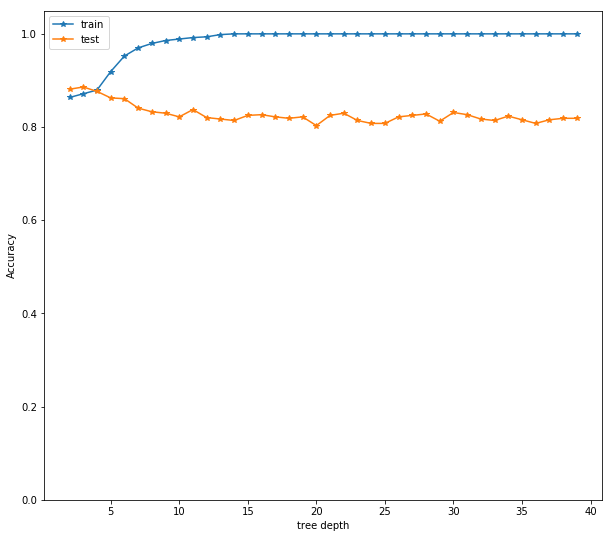

In [63]:
plt.figure(figsize=(10, 9))
plt.plot(depths, train_scores, '*-', label='train')
plt.plot(depths, test_scores, '*-', label='test')
plt.legend(loc='best')
plt.xlabel('tree depth')
plt.ylabel('Accuracy')
plt.ylim((0, 1.05))
plt.show()



In [64]:
clf = DecisionTreeClassifier(max_depth=3)
result_df=clf.fit(X_train, y_train)
print("Decision Tree:")
print ('Train score:', clf.score(X_train, y_train))
print ('Test score:', clf.score(X_test, y_test))
print ('Test score ADNI2:', clf.score(X_test_ADNI2, y_test_ADNI2))
print ('Test score ADNIGO:', clf.score(X_test_ADNIGO, y_test_ADNIGO))

Decision Tree:
Train score: 0.871428571429
Test score: 0.8859375
Test score ADNI2: 0.898044692737
Test score ADNIGO: 0.925287356322


In [65]:
y_train_df_pred=result_df.predict(X_train)
y_test_df_pred=result_df.predict(X_test)
y_test_df_pred_ADNI2=result_df.predict(X_test_ADNI2)
y_test_df_pred_ADNIGO=result_df.predict(X_test_ADNIGO)

print("Decision Tree:")
print("Confusion Matrix Train:")
print(confusion_matrix(y_train_df_pred, y_train))
print("Confusion Matrix Test:")
print(confusion_matrix(y_test_df_pred, y_test))

print("Confusion Matrix Test ADNI2:")
print(confusion_matrix(y_test_df_pred_ADNI2, y_test_ADNI2))

print("Confusion Matrix Test ADNIGO:")
print(confusion_matrix(y_test_df_pred_ADNIGO, y_test_ADNIGO))


Decision Tree:
Confusion Matrix Train:
[[154   0   7]
 [  0 140  15]
 [ 22  37 255]]
Confusion Matrix Test:
[[174   0   3]
 [  0 106  17]
 [ 27  26 287]]
Confusion Matrix Test ADNI2:
[[252   0   4]
 [  0  85   9]
 [ 32  28 306]]
Confusion Matrix Test ADNIGO:
[[ 36   0   1]
 [  0  14   1]
 [  6   5 111]]


In [67]:
dotfile = open("data/dtree2_DX_last.txt", 'w')
tree.export_graphviz(result_df, out_file = dotfile, feature_names = X_train.columns)
dotfile.close()